# Способы отрисовки поверхностей

## Расчеты SES поверхностей

Вот тут обозрены всякие методы (https://doi.org/10.1101/294025)
Какие методы можно выделить: 

Аналитические (Connoly PQMS https://doi.org/10.1016/0263-7855(93)87010-3, MSMS https://doi.org/10.1002/(SICI)1097-0282(199603)38:3<305::AID-BIP4>3.0.CO;2-Y). Плюсы: правильная поверхность, обычно в комплекте с триангуляцией, реализовано в пимоле. Минусы: долго, сложно, написано на эльфийском 200 лет назад. 

Решеточные (LSMS https://doi.org/10.1016/j.jmgm.2006.02.012, EDTSurf https://doi.org/10.1371/journal.pone.0008140). Плюсы: скорость (нет), треугольники. Минусы: нет нормалей, затратно (клятые воксели), написано на эльфийском.

dmasif (https://doi.org/10.1101/2020.12.28.424589) - градиентный спуск по функции smooth distance, фильтрация, сабсемплинг. Плюсы: быстро. Минусы: нестабильно, невоспроизводимо, лысые вогнутые места (хотя по факту должно быть наоборот), непроходимо для градиента. 

### Setup

In [1]:
# Dependencies
'''
! wget https://zhanggroup.org/EDTSurf/EDTSurf
! chmod u+x EDTSurf
! pip install -r requirements.txt

'''

'\n! wget https://zhanggroup.org/EDTSurf/EDTSurf\n! chmod u+x EDTSurf\n! pip install -r requirements.txt\n\n'

In [1]:
import sys,importlib
import torch
import os
import time
from tqdm import tqdm
import random
import numpy as np
import pandas as pd
from IPython.display import clear_output

import matplotlib.pyplot as plt
import plotly.express as px

#import pykeops
#pykeops.clean_pykeops()

%matplotlib inline 

[KeOps] .cache/pykeops2.1/gpu/ has been cleaned.
[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


### Метрики сходства для облаков точек

In [2]:
try:
    importlib.reload(sys.modules['dmasif_surface'])
    importlib.reload(sys.modules['compute_SES'])
    importlib.reload(sys.modules['losses'])

except KeyError:
    pass

from dmasif_surface import get_smooth_surface # тут функция из dmasif
from compute_SES import computeMSMS, computeEDTSurf # тут классические функции
from losses import chamfer_distance, hausdorff_distance, distribution # тут лоссы

pdb_dir='protein_data/'


Возьмем случайную структуру и рассчитаем для нее поверхность разными способами

In [3]:
pdb_file=pdb_dir+os.listdir(pdb_dir)[0] 

print(pdb_file)

msms_vert, msms_face, msms_norm=computeMSMS(pdb_file)
edt_vert, edt_face=computeEDTSurf(pdb_file)
dmasif_vert, dmasif_norm = get_smooth_surface(pdb_file)


protein_data/1U6B_C.pdb
[KeOps] Generating code for formula Sum_Reduction(Exp(-Sqrt(Sum((Var(0,3,0)-Var(1,3,1))**2))),1) ... OK
[KeOps] Generating code for formula Sum_Reduction((Var(0,1,0)*Exp(-Sqrt(Sum((Var(1,3,0)-Var(2,3,1))**2))))/Var(3,1,1),1) ... OK
[KeOps] Generating code for formula Max_SumShiftExpWeight_Reduction(Concat(-Sqrt(Sum((Var(0,3,0)-Var(1,3,1))**2))/Var(2,1,0),1),1) ... OK
[KeOps] Generating code for formula Sum_Reduction(-(-((2*(Var(0,3,0)-Var(1,3,1)))*(((Extract(Var(3,2,1),1,1)*Exp(-Sqrt(Sum((Var(0,3,0)-Var(1,3,1))**2))/Var(2,1,0)-Extract(Var(4,2,1),0,1)))/Var(2,1,0))*(1/2*Rsqrt(Sum((Var(0,3,0)-Var(1,3,1))**2)))))),1) ... OK
[KeOps] Generating code for formula Sum_Reduction(-(-((2*(Var(1,3,0)-Var(2,3,1)))*(((Var(0,1,0)*(Var(4,1,1)/Var(3,1,1)))*Exp(-Sqrt(Sum((Var(1,3,0)-Var(2,3,1))**2))))*(1/2*Rsqrt(Sum((Var(1,3,0)-Var(2,3,1))**2)))))),1) ... OK
[KeOps] Generating code for formula Sum_Reduction(-(((Var(0,1,0)*Exp(-Sqrt(Sum((Var(1,3,0)-Var(2,3,1))**2))))*Var(4,1,1))/V

Нарисуем результат

/home/domain/data/prog/miniconda3/envs/dmasif_upd/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


MSMS point number: 11732
dmasif point number: 2930
EDTSurf point number: 46631


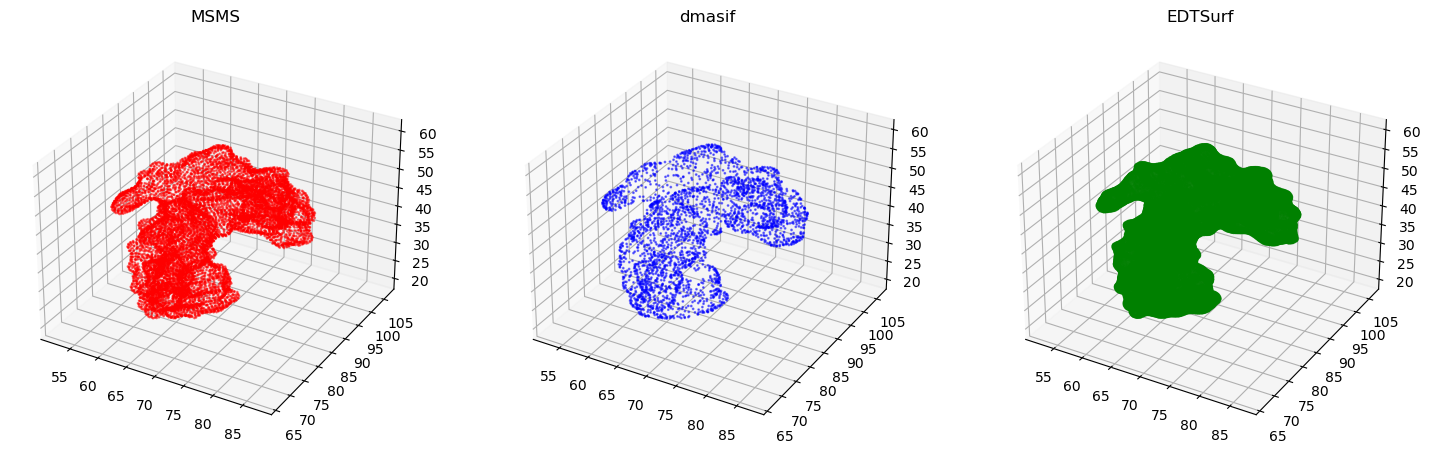

In [6]:
fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(*msms_vert.T, s=1, color='red',alpha=0.5)
ax.set_title('MSMS')

ax = fig.add_subplot(132, projection='3d')
ax.scatter(*dmasif_vert.T, s=1, color='blue',alpha=0.5)
ax.set_title('dmasif')

ax = fig.add_subplot(133, projection='3d')
ax.scatter(*edt_vert.T, s=1, color='green',alpha=0.5)
ax.set_title('EDTSurf')

fig.show()

print('MSMS point number:', msms_vert.shape[0])
print('dmasif point number:', dmasif_vert.shape[0])
print('EDTSurf point number:', edt_vert.shape[0])

Рассчитаем лоссы, сравним способ dmasif с MSMS (будем считать МSMS золотым стандартом)

In [92]:
d_ch_loss, d_norm_loss=chamfer_distance( dmasif_vert, torch.Tensor(msms_vert), dmasif_norm, torch.Tensor(msms_norm), single_directional=True)
d_haus_dist=hausdorff_distance(dmasif_vert, torch.Tensor(msms_vert))
print('Chamfer distance:',d_ch_loss.item())
print('Normal distance:',d_norm_loss.item())
print('Hausdorff distance:',d_haus_dist.item())

Chamfer distance: 0.3386051654815674
Normal distance: 0.08630812168121338
Hausdorff distance: 3.516693115234375


In [93]:
msms_dist=distribution(torch.Tensor(msms_vert), reduction='max')
dmasif_dist=distribution(dmasif_vert, reduction='max')
print('MSMS distribution:',msms_dist.item())
print('dMaSIF distribution:',dmasif_dist.item())

[KeOps] Generating code for formula Sum_Reduction(Step(Var(2,1,2)-Sum((Var(0,3,0)-Var(1,3,1))**2)),0) ... OK
MSMS distribution: 19.218650817871094
dMaSIF distribution: 9.487260818481445


### Простой метод

Сделаем самую простую детскую модель, которая будет просто рисовать рандомные точки по SAS поверхности, удалять внутренние точки, перемещать точки на радиус пробы и усреднять грид кластерингом для получения условной SES поверхности. 

In [76]:
try:
    importlib.reload(sys.modules['simple_surface'])
except KeyError:
    pass
from simple_surface import get_simple_surface

In [95]:
my_vert, my_norm = get_simple_surface(pdb_file)


2186 3 300


Проблема: для получения приемлевого количества точек нужно генерировать по 300 точек на атом, что может создать ограничения по памяти. При этом большая часть этих точек в итоге никак не сыграет, а будет отфильтрована. Была сделана попытка генерировать и отфильтровывать точки символьными функциями, но keops не работает с таким количеством измерений. 

MSMS point number: 31228
dMaSIF point number: 8164
Mine point number: 8653


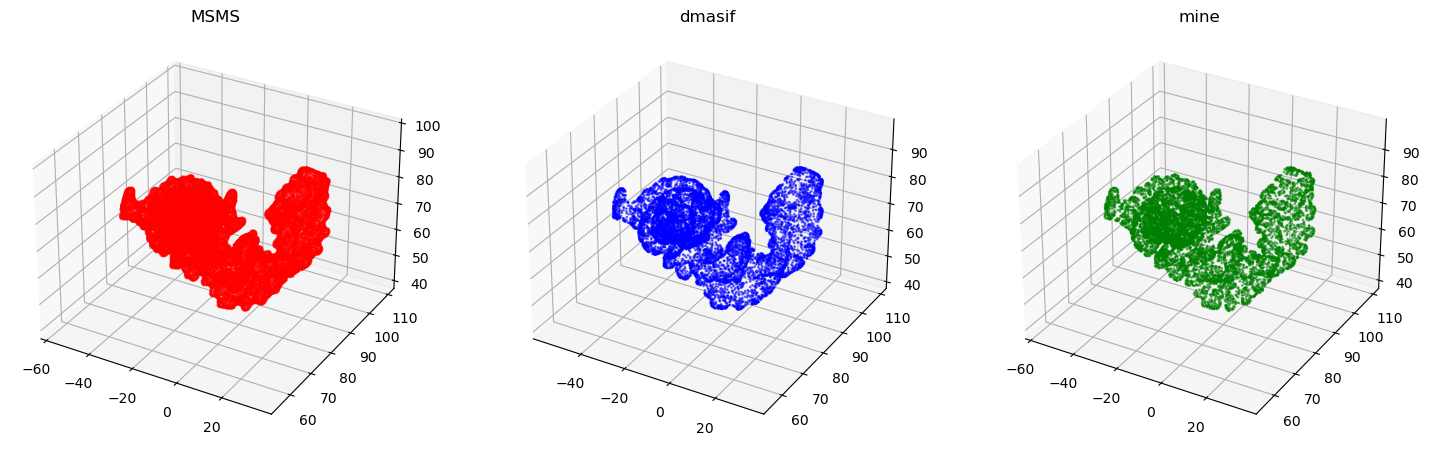

In [96]:
fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(*msms_vert.T, s=1, color='red',alpha=0.5)
ax.set_title('MSMS')

ax = fig.add_subplot(132, projection='3d')
ax.scatter(*dmasif_vert.T, s=1, color='blue',alpha=0.5)
ax.set_title('dmasif')

ax = fig.add_subplot(133, projection='3d')
ax.scatter(*my_vert.T, s=1, color='green',alpha=0.5)
ax.set_title('mine')

print('MSMS point number:', msms_vert.shape[0])
print('dMaSIF point number:', dmasif_vert.shape[0])
print('Mine point number:', my_vert.shape[0])


In [97]:
m_ch_loss, m_norm_loss=chamfer_distance( my_vert, torch.Tensor(msms_vert), my_norm, torch.Tensor(msms_norm), single_directional=True)
m_haus_dist=hausdorff_distance(my_vert, torch.Tensor(msms_vert))
print('Chamfer distance:',m_ch_loss.item())
print('Normal distance:',m_norm_loss.item())
print('Hausdorff distance:',m_haus_dist.item())

my_dist=distribution(my_vert, reduction='max')
print('Distribution:',my_dist.item())

Chamfer distance: 0.26887452602386475
Normal distance: 0.02708578296005726
Hausdorff distance: 2.098378896713257
Distribution: 6.810123443603516


In [98]:
loss_col=chamfer_distance( my_vert, torch.Tensor(msms_vert),reduction=None)

fig=px.scatter_3d(x=my_vert[:,0],y=my_vert[:,1],z=my_vert[:,2], color=loss_col[0][0][:,0].log())
fig.update_traces(marker={'size': 2})
fig.update_layout(
    autosize=False, 
    width=1200, 
    height=800,
    scene = dict(
        xaxis = dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis = dict(showgrid=False, zeroline=False, showticklabels=False),
        zaxis = dict(showgrid=False, zeroline=False, showticklabels=False),
    )
)

In [99]:
pd.DataFrame(index=['dmasif','mine'], columns=['chamfer','normal','hausdorff','distribution'],
             data=[[d_ch_loss.item(),d_norm_loss.item(), d_haus_dist.item(), dmasif_dist.item()],
                   [m_ch_loss.item(),m_norm_loss.item(), m_haus_dist.item(), my_dist.item()]])

,chamfer,normal,hausdorff,distribution
dmasif,0.338605,0.086308,3.516693,9.487261
mine,0.268875,0.027086,2.098379,6.810123


Результаты детского метода сравнимы с методом dmasif

## Нейронки

Для расчета точек поверхности нейронок нет, значит, можно написать самостоятельно

### Датасет

Сделаем неизбыточную выборку структур макромолекул. Я брала так: искала в pdb "CASP target", фильтровала asymmetric units и кластеризовала по 30% сходству, получилось 2337 белков, не совпадающих с белками из предыдущих выборок для обучения masif. Также нашла в недрах интернета выборку из 2863 неизбыточных РНК (https://doi.org/10.1093/nargab/lqad040) и тоже досыпала в свой датасет. Все это могущество протонировала.

In [ ]:
# Download and protonate pdbs
'''
! mkdir protein_data/
! python3 download_pdb.py -pdb_list prot_nrd.txt
! python3 download_pdb.py -pdb_list rna_nrd_2.txt

# или, если надо быстрее

! gdown https://drive.google.com/file/d/1UrGXZrizq4pb0UBm8feCpc9tAKrkayed

'''

In [3]:
try:
    importlib.reload(sys.modules['data'])
    importlib.reload(sys.modules['losses'])
except KeyError:
    pass
from data import AtomSurfaceDataset, CollateDict
from losses import SurfaceCriterion

In [4]:
dataset=AtomSurfaceDataset(storage='structure_data.pkl') 
print(dataset[0].keys())
print(f'Dataset length: {len(dataset)}')

dict_keys(['atom_xyz', 'atom_rad', 'target_xyz', 'target_normals'])
Dataset length: 5077


In [5]:
train_set, val_set, _ = torch.utils.data.random_split(dataset, [77,50,4950])

In [6]:
device=torch.device(0) if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [55]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True, collate_fn=CollateDict(device=device))
val_loader = torch.utils.data.DataLoader(val_set, batch_size=8, shuffle=False, collate_fn=CollateDict(device=device))

### Модель

In [56]:
import torch 
import torch.nn as nn
from pykeops.torch import LazyTensor
from batching import diagonal_ranges

Я переписала модель, теперь она выглядит пологичнее. Что там происходит: генерируются случайные точки вокруг каждого атома. Ищутся ближайшие к точке атомы, находятся расстояния и направления до них. Расстояния конкатенируются с фичами атомов (радиусами) и преобразуются полносвязными слоями. Затем полученные фичи домножаются на направления и суммируются по ближайшим атомам. Полученные векторы опять раскладываются на расстояния и направления. Расстояния преобразуются линейными слоями, а направления конкатенируются с нормалями. Все это снова перемножается, и оттуда вычленяются векторы, на которые будут изменены координаты и нормали. Это делается несколько раз (вот тут не уверена, будет ли через такую модель хорошо проходить градиентный спуск?)

In [57]:
torch.cuda.empty_cache()

In [88]:

def knn_atoms(x, y, x_batch=None, y_batch=None, k=16):
    N, D = x.shape
    x_i = LazyTensor(x[:, None, :])
    y_j = LazyTensor(y[None, :, :])

    pairwise_distance_ij = ((x_i - y_j) ** 2).sum(-1)
    if x_batch!=None and y_batch!=None:
        pairwise_distance_ij.ranges = diagonal_ranges(x_batch, y_batch)

    # N.B.: KeOps doesn't yet support backprop through Kmin reductions...
    # dists, idx = pairwise_distance_ij.Kmin_argKmin(K=k,axis=1)
    # So we have to re-compute the values ourselves:
    idx = pairwise_distance_ij.argKmin(K=k, axis=1)  # (N, K)
    x_ik = y[idx.view(-1)].view(N, k, D)
    dists = ((x[:, None, :] - x_ik) ** 2).sum(-1).sqrt()

    return idx, dists

class AtomShift(nn.Module):
    def __init__(self, in_dims, emb_dims, k=8):
        super(AtomShift, self).__init__()
        self.in_dims = in_dims
        self.emb_dims = emb_dims
        self.k = k
        
        self.norm=nn.BatchNorm1d(self.k)

        self.transform_types = nn.Sequential(
            nn.Linear(self.in_dims+1,self.emb_dims),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(self.emb_dims, self.emb_dims),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(self.emb_dims, self.emb_dims),
            nn.LeakyReLU(negative_slope=0.2),
        )

        self.emb = nn.Sequential(
            nn.Linear(self.emb_dims, self.emb_dims+1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(self.emb_dims+1, self.emb_dims*2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(self.emb_dims*2, (self.emb_dims+1)*2),
        )

    def forward(self, xyz, norm, atom_xyz, atomtypes, batch, atom_batch):

        idx, dists = knn_atoms(xyz, atom_xyz, batch, atom_batch, k=self.k)
        vecs=(xyz[:,None,:]-atom_xyz[idx.view(-1), :].view(-1, self.k, 3))/dists[:,:,None]

        if len(atomtypes.shape)<2:
            atomtypes=atomtypes[:,None]
        fx=torch.cat((atomtypes[idx.view(-1), :].view(-1, self.k, self.in_dims),
                      dists[:,:,None]), dim=-1) 
        fx=self.transform_types(fx) #(N, k, emb_dims)
        fx=self.norm(fx)
        vecs=(fx[:,:,None,:]*vecs[:,:,:,None]).sum(1) #(N, 3, emb_dims)

        fx=(vecs**2).sum(1).sqrt() #(N, emb_dims)
        vecs=vecs/fx[:,None,:] #(N, 3, emb_dims)
        vecs=torch.cat((norm[:,:,None], vecs), dim=-1) 

        fx=self.emb(fx).view(-1,2,self.emb_dims+1)
        fx=(fx[:,None,:,:]*vecs[:,:,None,:]).sum(-1)

        dxyz = fx[:,:,0]
        dnorm = fx[:,:,1]

        return dxyz, dnorm

class ShiftModel(nn.Module):

    def __init__(self, distance=1.05, sup_sampling=20, n_shifts=4,variance=0.1):
        super(ShiftModel, self).__init__()

        self.distance=distance
        self.sup_sampling=sup_sampling
        self.n_shifts=n_shifts
        self.variance=variance
        self.shift=AtomShift(in_dims=1, emb_dims=4)
        
    '''
    # этот вариант немного ротационно неинвариантен, 
    # тк семплит случайные точки вокруг атома, 
    # в кубической окрестности соответственно осям
 
    def init_points(self, prot):

        atoms=prot['atom_xyz']
        batch_atoms = prot['atom_xyz_batch']

        T = self.distance
        N, D = atoms.shape
        B = self.sup_sampling 

        r =  T * torch.randn(N, B, D).type_as(atoms)
        z = (atoms[:, None, :] + r).view(-1, D) 
        norm = (r / (r**2).sum(1, keepdim=True).sqrt()).view(-1, D)
 
        prot['xyz']=z
        prot['normals']=norm
        if 'atom_xyz_batch' in prot:
            batch_z = batch_atoms[:, None].repeat(1, B).view(N * B)
            prot['xyz_batch']=batch_z
    '''
    
    # этот вариант семплит точки на поверхности каждого атома.
    # гипотетически это может упрощать модели задачу
    
    def init_points(self, prot):
        
        atoms=prot['atom_xyz']       

        N, D = atoms.shape
        B = self.sup_sampling 

        nb=torch.randn(B, D).type_as(atoms)
        nb /= (nb**2).sum(-1, keepdim=True).sqrt()

        if 'atom_rad' in prot:
            atom_rad=prot['atom_rad']
            z=atoms[:,None,:] + atom_rad[:,None,None] * nb[None,:,:]
        else:
            z=atoms[:,None,:] + self.distance * nb[None,:,:]

        nb = nb[None,:,:].repeat(N, 1, 1 ).view(N * B, D)
        z=z.view(N * B, D)
        
        prot['xyz']=z
        prot['normals']=nb
        
        if 'atom_xyz_batch' in prot:
            batch_atoms = prot['atom_xyz_batch']
            batch_z = batch_atoms[:, None].repeat(1, B).view(N * B)
            prot['xyz_batch']=batch_z
    
    def remove_outliers(self, prot):
        idx, dists = knn_atoms(prot['xyz'], prot['atom_xyz'], 
                               prot.get('xyz_batch'),
                               prot.get('atom_xyz_batch'), 
                               k=1)
        mask=(dists[:,0] >= ((prot['atom_rad'][idx[:,0]]-self.variance)**2))
        mask*=(dists[:,0] <= ((prot['atom_rad'][idx[:,0]]+self.variance)**2))
        prot['xyz'] = prot['xyz'][mask]
        prot['normals'] = prot['normals'][mask]
        if 'xyz_batch' in prot:
            prot['xyz_batch'] = prot['xyz_batch'][mask]
            
    def blur(self, prot):
        s=0.1
        k=16
        idx, dists = knn_atoms(prot['xyz'], prot['xyz'], 
                               prot.get('xyz_batch'),
                               prot.get('xyz_batch'), 
                               k=k)
        dists=torch.exp(-0.5*(dists/s)**2)/(s*(2*torch.pi)**0.5)
        prot['xyz']=(prot['xyz'][idx.view(-1),:].view(-1,k,3)*dists[:,:,None]).sum(1)
        prot['normals']=(prot['normals'][idx.view(-1),:].view(-1,k,3)*dists[:,:,None]).sum(1)
        prot['normals']=prot['normals']/(prot['normals']**2).sum(-1).sqrt()[:,None]
            

    def forward(self, prot, n_shifts=None):
        if 'xyz' not in prot:
            self.init_points(prot)
        if n_shifts==None:
            n_shifts=self.n_shifts
        
        for _ in range(n_shifts):        
            dxyz, dnorm=self.shift(
                prot['xyz'],prot['normals'],
                prot['atom_xyz'],prot['atom_rad'],
                prot.get('xyz_batch'),prot.get('atom_xyz_batch'))
            prot['xyz']+=dxyz
            prot['normals']=dnorm
            prot['normals']=prot['normals']/(prot['normals']**2).sum(-1).sqrt()[:,None]
        if not self.training:
            self.remove_outliers(prot)
            #self.blur(prot)
        
        return prot

Обучим модель. Как обучать: можно оптимизировать после каждого прогона модели, а можно - после каждого сдвига точки. 

In [69]:
def detach_dict(d):
    for value in d.values():
        value.detach()

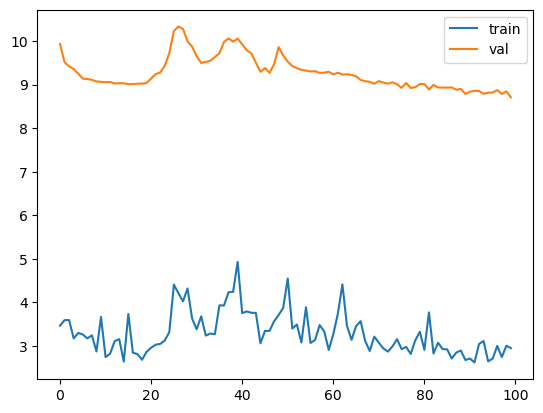

In [70]:
model=ShiftModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
criterion = SurfaceCriterion(hausdorff_weight=0,distribution_weight=0)
n_epochs=100 

train_losses=[]
val_losses=[]

for epoch in range(n_epochs):  # number of epochs
    model.train()
    training_loss = 0
    for data in train_loader: 
        
        # оптимизируем после каждого батча
        optimizer.zero_grad()
        out=model(data)
        loss = criterion(out)
        loss.backward()
        optimizer.step()
        
        '''
        # оптимизируем после каждого сдвига
        # почему-то не работает  
        for _ in range(model.n_shifts):
            
            optimizer.zero_grad()
            detach_dict(data)
            data=model(data, n_shifts=1) 
            loss = criterion(data)
            loss.backward()
            optimizer.step()
        '''            
        training_loss += loss.item()
    #print(f'Training loss: {training_loss/len(train_loader)}')
    train_losses.append(training_loss/len(train_loader))
    model.eval()
    val_loss = 0
    for data in val_loader: 
        out = model(data)
        loss = criterion(out)
        
        val_loss += loss.item()
    #print(f'Validation loss: {val_loss/len(val_loader)}')
    val_losses.append(val_loss/len(val_loader))

    clear_output()
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.legend()
    plt.show()

In [89]:
#torch.save(model.to('cpu'),'model.ptc')

model=torch.load('model.ptc')

In [90]:
model.eval()

ShiftModel(
  (shift): AtomShift(
    (norm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (transform_types): Sequential(
      (0): Linear(in_features=2, out_features=4, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=4, out_features=4, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=4, out_features=4, bias=True)
      (5): LeakyReLU(negative_slope=0.2)
    )
    (emb): Sequential(
      (0): Linear(in_features=4, out_features=5, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=5, out_features=8, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=8, out_features=10, bias=True)
    )
  )
)

Обучается плохо, надо бы оптимизировать гиперпараметры, повставлять всякие нормализации, уточнить лоссы.

Почему-то все лоссы кроме chamfer дают отвратительный результат. Возможно, я где-то напортачила в коде. А может, они строгие очень просто.

In [91]:
from data import load_structure_np



In [92]:
pdb_file=pdb_dir+os.listdir(pdb_dir)[20] 

print(pdb_file)

protein_data/6SGA_FY.pdb


In [93]:
msms_vert, msms_face, msms_norm=computeMSMS(pdb_file)
dmasif_vert, dmasif_norm = get_smooth_surface(pdb_file)
simple_vert, simple_norm = get_simple_surface(pdb_file)
nn_prot = model(load_structure_np(pdb_file))

1079 3 300


In [94]:
df_res=pd.DataFrame(index=['dmasif','simple', 'nn'], columns=['chamfer','normal','hausdorff','distribution'])
a=chamfer_distance( dmasif_vert, torch.Tensor(msms_vert), 
                    dmasif_norm, torch.Tensor(msms_norm), 
                    single_directional=True)
df_res['chamfer']['dmasif'], df_res['normal']['dmasif']= a[0].detach().item(),a[1].detach().item()
a=chamfer_distance( simple_vert, torch.Tensor(msms_vert), 
                    simple_norm, torch.Tensor(msms_norm), 
                    single_directional=True)
df_res['chamfer']['simple'], df_res['normal']['simple']=a[0].detach().item(),a[1].detach().item()
a=chamfer_distance( nn_prot['xyz'], torch.Tensor(msms_vert), 
                    nn_prot['normals'], torch.Tensor(msms_norm), 
                    single_directional=True)
df_res['chamfer']['nn'], df_res['normal']['nn']=a[0].detach().item(),a[1].detach().item()

df_res['hausdorff']['dmasif']=hausdorff_distance(dmasif_vert, torch.Tensor(msms_vert)).detach().item()
df_res['hausdorff']['simple']=hausdorff_distance(simple_vert, torch.Tensor(msms_vert)).detach().item()
df_res['hausdorff']['nn']=hausdorff_distance(nn_prot['xyz'], torch.Tensor(msms_vert)).detach().item()


df_res['distribution']['dmasif']=distribution(dmasif_vert, reduction='max').detach().item()
df_res['distribution']['simple']=distribution(simple_vert, reduction='max').detach().item()
df_res['distribution']['nn']=distribution(nn_prot['xyz'], reduction='max').detach().item()

df_res

,chamfer,normal,hausdorff,distribution
dmasif,0.319117,0.083119,4.352885,7.553846
simple,0.275196,0.033614,2.429651,5.74464
nn,0.410283,0.176236,3.6903,35.671947


MSMS point number: 14790
DMaSIF point number: 3445
Simple point number: 3685
NN point number: 7511


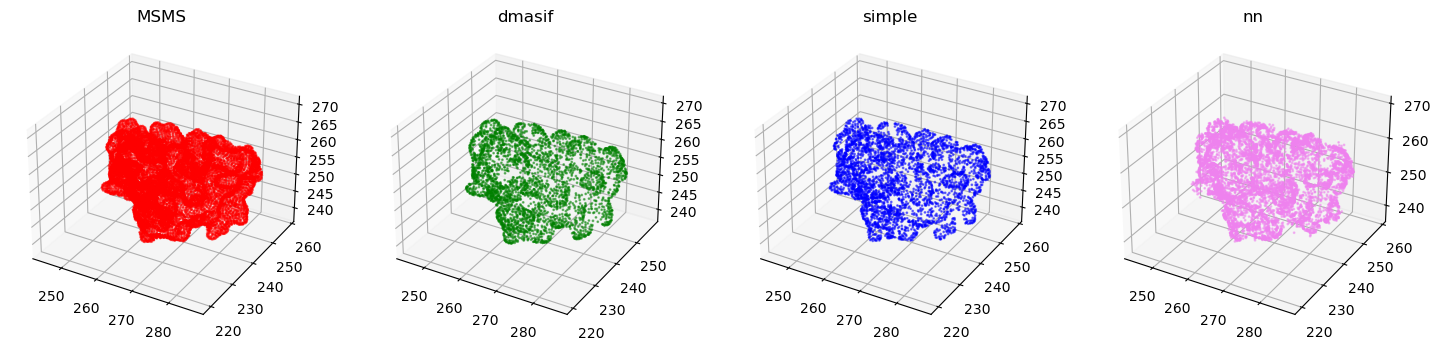

In [95]:
fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(141, projection='3d')
ax.scatter(*msms_vert.T, s=1, color='red',alpha=0.5)
ax.set_title('MSMS')

ax = fig.add_subplot(142, projection='3d')
ax.scatter(*dmasif_vert.T, s=1, color='green',alpha=0.5)
ax.set_title('dmasif')

ax = fig.add_subplot(143, projection='3d')
ax.scatter(*simple_vert.T, s=1, color='blue',alpha=0.5)
ax.set_title('simple')

ax = fig.add_subplot(144, projection='3d')
ax.scatter(*nn_prot['xyz'].detach().numpy().T, s=1, color='violet',alpha=0.5)
ax.set_title('nn')

print('MSMS point number:',msms_vert.shape[0])
print('DMaSIF point number:',dmasif_vert.shape[0])
print('Simple point number:',simple_vert.shape[0])
print('NN point number:',nn_prot['xyz'].shape[0])


plt.show()


In [96]:
loss_col=chamfer_distance( nn_prot['xyz'], torch.Tensor(msms_vert),reduction=None)

fig=px.scatter_3d(x=nn_prot['xyz'][:,0].detach(),y=nn_prot['xyz'][:,1].detach(),z=nn_prot['xyz'][:,2].detach(), 
                  color=loss_col[0][0].detach().log())
fig.update_traces(marker={'size': 2})
fig.update_layout(
    autosize=False, 
    width=800, 
    height=400,
    scene = dict(
        xaxis = dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis = dict(showgrid=False, zeroline=False, showticklabels=False),
        zaxis = dict(showgrid=False, zeroline=False, showticklabels=False),
    )
)

## Способы триангуляции

Это пока не нужно

In [ ]:
import numpy as np
import k3d
from compute_triangles import split_triangles, delaunay

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
#cells=split_triangles(my_vert)
cells=delaunay(my_vert)

In [ ]:
plot = k3d.plot()
plot+=k3d.points(my_vert, point_size=0.2, shader='flat')
plot+=k3d.mesh(my_vert,cells, side='double', color=0x32ff31)

plot.display()

Output()